# English Wikipedia page views, 2008 - 2017

For this assignment, your job is to analyze traffic on English Wikipedia over time, and then document your process and the resulting dataset and visualization according to best practices for open research that were outlined for you in class.

### Example API request
You can use this example API request as a starting point for building your API queries. Note that the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) has slightly different schema than the [pageview API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) shown here.

This sample API request would get you all pageviews by web crawlers on the mobile website for English Wikipedia during the month of September, 2017.

In [2]:
import requests

endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers={'User-Agent' : 'https://github.com/your_github_username', 'From' : 'your_uw_email@uw.edu'}

params = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-web',
            'agent' : 'spider',
            'granularity' : 'monthly',
            'start' : '2017090100',
            'end' : '2017111000'#use the first day of the following month to ensure a full month of data is collected
            }

api_call = requests.get(endpoint.format(**params))
response = api_call.json()
print(response)


{'items': [{'project': 'en.wikipedia', 'access': 'mobile-web', 'agent': 'spider', 'granularity': 'monthly', 'timestamp': '2017090100', 'views': 69790930}]}


# Step 1: Data acquisition

Pull page views through wikimedia API from July 2015 an onward.

In [533]:
import requests

endpoint_views = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

params_views = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-web',
            'agent' : 'user',
            'granularity' : 'monthly',
          'start' : '2015070100',
            'end' : '2017111000'
            }

mobile_web_views = requests.get(endpoint_views.format(**params_views))

params_views['access'] = 'mobile-app'
mobile_app_views = requests.get(endpoint_views.format(**params_views))

params_views['access'] = 'desktop'
desktop_views = requests.get(endpoint_views.format(**params_views))

Pull page counts through wikimedia API from January 2018 through August 2016.

In [547]:
endpoint_counts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

params_count = {'project' : 'en.wikipedia.org',
            'access-site' : 'desktop-site',
            'granularity' : 'monthly',
            'start' : '2008010100',
            'end' : '2017111000'
            }

desktop_counts = requests.get(endpoint_counts.format(**params_count))

params_count['access-site'] = 'mobile-site'
mobile_counts = requests.get(endpoint_counts.format(**params_count))

In [548]:
print(desktop_views)

<Response [200]>


# Step 2: Data processing

Put the page view data into a pandas dataframe

In [549]:
import pandas as pd
import json
from pandas.io.json import json_normalize

In [550]:
#Pull mobile and desktop view data into Pandas DataFrames.
data_mobile_web_views = json_normalize(json.loads(mobile_web_views.text)['items'])
data_mobile_app_views = json_normalize(json.loads(mobile_app_views.text)['items'])
data_desktop_views = json_normalize(json.loads(desktop_views.text)['items'])

In [551]:
#Join view data into one DataFrame.
data_views = pd.merge(data_mobile_web_views,data_mobile_app_views,on='timestamp',how='outer')
data_views = pd.merge(data_views,data_desktop_views,on='timestamp',how='outer')

In [552]:
#Get rid of extra columns and rename columns in view data.
data_views['pageview_mobile_views'] = data_views['views_x'] + data_views['views_y']
data_views['pageview_all_views'] = data_views['pageview_mobile_views'] + data_views['views']
data_views = data_views.drop(data_views.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,14]],axis=1)
data_views.columns = ['timestamp','pageview_desktop_views','pageview_mobile_views','pageview_all_views']
data_views.head(1)

,timestamp,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2015070100,4376666686,3288755294,7665421980


In [553]:
#Pull mobile and desktop count data into Pandas DataFrames.
data_desktop_counts = json_normalize(json.loads(desktop_counts.text)['items'])
data_mobile_counts = json_normalize(json.loads(mobile_counts.text)['items'])

In [554]:
#Join count data into one DataFrame.
data_counts = pd.merge(data_desktop_counts,data_mobile_counts,on='timestamp',how='outer')
data_counts = data_counts.fillna(0)

In [555]:
#Get rid of extra columns and rename columns in count data.
data_counts['pageview_all_views'] = data_counts['count_x'] + data_counts['count_y']
data_counts = data_counts.drop(data_counts.columns[[0,2,3,5,7,8]],axis=1)
data_counts.columns = ['pagecount_desktop_views','timestamp','pagecount_mobile_views','pagecount_all_views']
data_counts.head(1)

,pagecount_desktop_views,timestamp,pagecount_mobile_views,pagecount_all_views
0,4930902570,2008010100,0.0,4.930903e+09


In [560]:
#Join count and view data together. Separate year and month. Re-arrange columns.
data = pd.merge(data_counts,data_views,on='timestamp',how='outer')
data['year'] = data['timestamp'].str[:4]
data['month'] = data['timestamp'].str[4:6]
data = data[['timestamp','year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
data = data.fillna(0)
data = data.apply(pd.to_numeric)
data.sort_values(['timestamp'],ascending=[True])
data['timestamp'] = pd.to_datetime(data['timestamp'].astype(str).str[0:8],format='%Y%m%d')
data

,timestamp,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008-01-01,2008,1,4.930903e+09,4.930903e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2008-02-01,2008,2,4.818394e+09,4.818394e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2008-03-01,2008,3,4.955406e+09,4.955406e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2008-04-01,2008,4,5.159162e+09,5.159162e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2008-05-01,2008,5,5.584691e+09,5.584691e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,2008-06-01,2008,6,5.712104e+09,5.712104e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,2008-07-01,2008,7,5.306303e+09,5.306303e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,2008-08-01,2008,8,5.140156e+09,5.140156e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,2008-09-01,2008,9,5.479534e+09,5.479534e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2008-10-01,2008,10,5.679441e+09,5.679441e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [557]:
#Export to csv
path = 'C:/Users/geoffc.REDMOND/OneDrive/Data512'
#/en-wikipedia_traffic_200801-201709.csv
#data.to_csv(path_or_buf=path,sep=',', encoding='utf-8')

# Step 3: Analysis

In [558]:
data_pc

,timestamp,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008-01-01,2008,1,9.154429e+09,9.154429e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2008-02-01,2008,2,8.843288e+09,8.843288e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2008-03-01,2008,3,9.191927e+09,9.191927e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2008-04-01,2008,4,9.645857e+09,9.645857e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2008-05-01,2008,5,1.069642e+10,1.069642e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,2008-06-01,2008,6,1.086264e+10,1.086264e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,2008-07-01,2008,7,9.872117e+09,9.872117e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,2008-08-01,2008,8,9.821076e+09,9.821076e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,2008-09-01,2008,9,1.063450e+10,1.063450e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2008-10-01,2008,10,1.106030e+10,1.106030e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


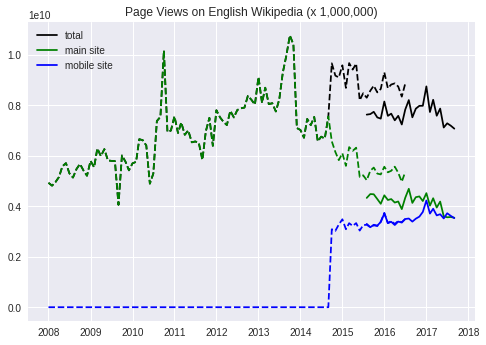

In [559]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
data_pc = data[(data['timestamp']<datetime.date(2016,8,1))]
data_pv = data[(data['timestamp']>datetime.date(2015,7,1))]

plt.plot("timestamp","pagecount_all_views",data=data_pc,c='black',linestyle='--')
plt.plot("timestamp","pagecount_desktop_views",data=data_pc,c='green',linestyle='--')
plt.plot("timestamp","pagecount_mobile_views",data=data_pc,c='blue',linestyle='--')
line1, = plt.plot("timestamp","pageview_all_views",data=data_pv,c='black',linestyle='solid',label='total')
line2, = plt.plot("timestamp","pageview_desktop_views",data=data_pv,c='green',linestyle='solid',label='main site')
line3, = plt.plot("timestamp","pageview_mobile_views",data=data_pv,c='blue',linestyle='solid',label='mobile site')
plt.legend(handles=[line1,line2,line3],loc="upper left")
plt.title('Page Views on English Wikipedia (x 1,000,000)')
#plt.ticklabel_format(style='plain',axis='y')
#ticks = plt.get_yticks()/1000000
#plt.set_yticklabels(ticks)
sns.plt.show()